### Modeling Time Series - Temp Data, Berlin, Tempelhof

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn import preprocessing
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

##### 1. Initial Exploration

In [2]:
# load data
df = pd.read_csv('data/TG_STAID002759.txt', skiprows=19, parse_dates=[1], index_col=1)

In [3]:
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2022-03-27,111448,97,0
2022-03-28,111448,108,0
2022-03-29,111448,80,0


In [4]:
# last value missing - remove
df = df.drop('2022-03-31')

In [5]:
df.describe()

,SOUID,TG,Q_TG
count,53415.000000,53415.000000,53415.000000
mean,119349.064944,57.049480,0.032875
std,8023.698310,613.766481,0.542814
min,111448.000000,-9999.000000,0.000000
25%,111448.000000,33.000000,0.000000
50%,111448.000000,93.000000,0.000000
75%,127488.000000,157.000000,0.000000
max,128124.000000,305.000000,9.000000


In [6]:
# Column names have spaces - clean
df.rename(columns={' SOUID' : 'ID', '   TG':'TG', ' Q_TG':'Q'}, inplace=True)

In [7]:
# transform Temperature *0.1 (according to info on website)
df['TG'] = df['TG']*0.1

In [8]:
# Check Data for Missing Values
df['Q'].value_counts()

0    53219
9      195
1        1
Name: Q, dtype: int64

##### 2. Dealing with missing values (Predicting with a model)

In [9]:
# Add Features
df['year'] = df.index.year
df['month'] = df.index.month_name()
df['day'] = df.index.day_name()

In [10]:
# Change Categorical to Numeric

le = preprocessing.LabelEncoder()
le.fit(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
df['day'] = le.transform(df['day']) 

In [11]:
le1 = preprocessing.LabelEncoder()
le1.fit(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
df['month'] = le1.transform(df['month']) 

In [12]:
# df with missing values
data_9999 = df[df["Q"]==9]

In [13]:
data_9999

,ID,TG,Q,year,month,day
DATE,,,,,,
1945-04-25,127488,-999.9,9,1945,0,6
1945-04-26,127488,-999.9,9,1945,0,4
1945-04-27,127488,-999.9,9,1945,0,0
1945-04-28,127488,-999.9,9,1945,0,2
1945-04-29,127488,-999.9,9,1945,0,3
...,...,...,...,...,...,...
1945-11-01,127488,-999.9,9,1945,9,4
1945-11-02,127488,-999.9,9,1945,9,0
1945-11-03,127488,-999.9,9,1945,9,2


In [14]:
# data without missing values (past only)
data_0 = df.loc[:'1945-04-24']

In [15]:
# create the model
rfModel_temp = RandomForestRegressor()

In [16]:
# define X and y
X = data_0[['year', 'month', 'day']]
y = data_0['TG']

In [17]:
# fitting the model 
rfModel_temp.fit(X,y)

RandomForestRegressor()

In [18]:
# taking relevant columns for X1 to predict missing values
X1 = data_9999[['year', 'month', 'day']]

In [19]:
# making the predictions for the missing values using the RF model
values_9999 = rfModel_temp.predict(X= X1)
values_9999.shape

(195,)

In [20]:
df_values = pd.DataFrame(values_9999, index=data_9999.index)

In [21]:
# Adding predicted values to Table
df.loc[df['Q'] == 9, 'TG'] = df_values.loc[:, 0]

##### 3. Data Exploration

(1000.0, 3000.0)

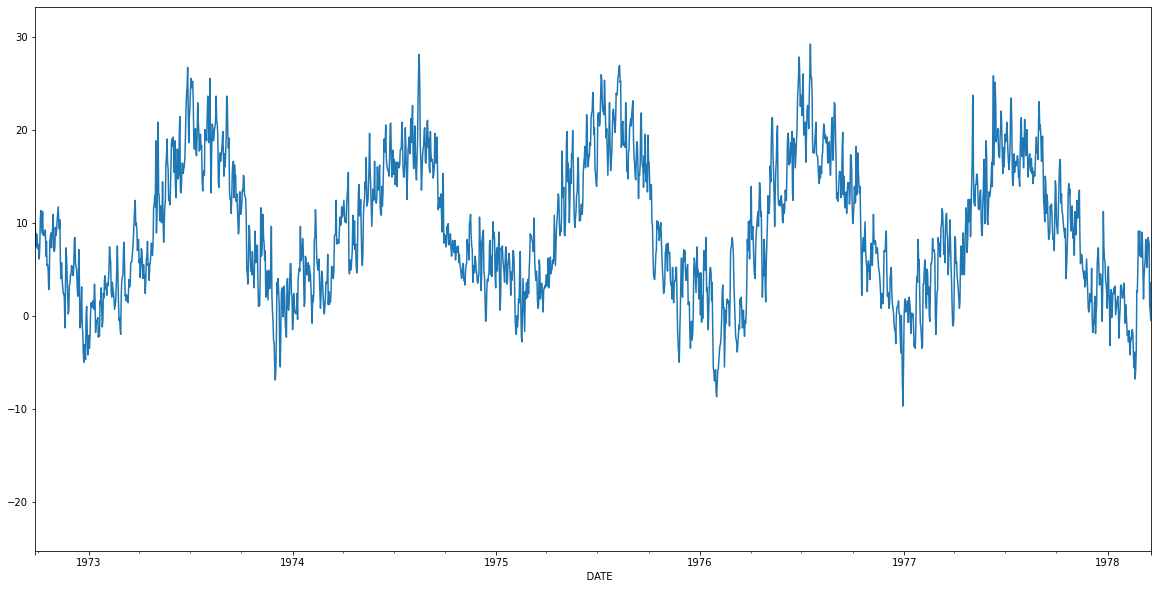

In [22]:
df['TG'].plot(figsize=(20,10))
plt.xlim(1000, 3000)

<AxesSubplot:xlabel='year'>

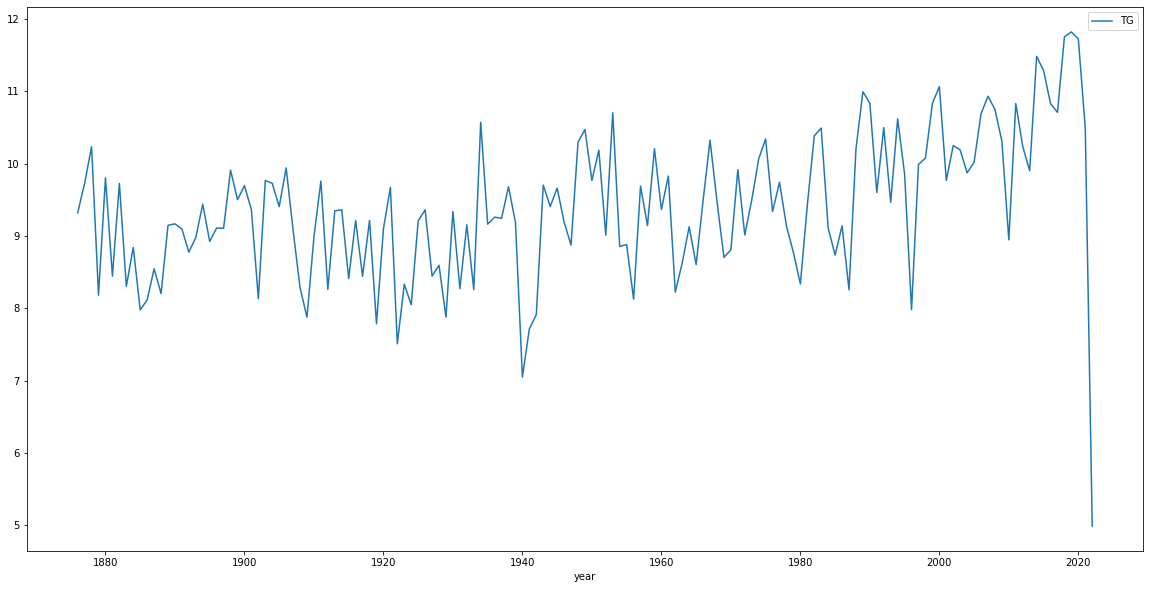

In [23]:
df.groupby(df['year'])['TG'].mean().plot(legend=True, figsize=(20,10))

<AxesSubplot:xlabel='    DATE'>

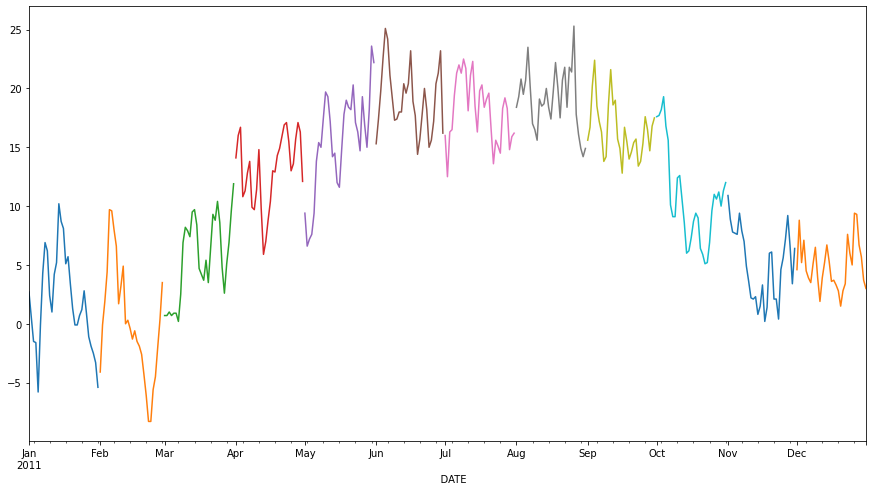

In [24]:
df['TG']['2011-01'].plot(figsize=(15, 8))
df['TG']['2011-02'].plot(figsize=(15, 8))
df['TG']['2011-03'].plot(figsize=(15, 8))
df['TG']['2011-04'].plot(figsize=(15, 8))
df['TG']['2011-05'].plot(figsize=(15, 8))
df['TG']['2011-06'].plot(figsize=(15, 8))
df['TG']['2011-07'].plot(figsize=(15, 8))
df['TG']['2011-08'].plot(figsize=(15, 8))
df['TG']['2011-09'].plot(figsize=(15, 8))
df['TG']['2011-10'].plot(figsize=(15, 8))
df['TG']['2011-11'].plot(figsize=(15, 8))
df['TG']['2011-12'].plot(figsize=(15, 8))

##### Conclusions:
* very minimal Trend over years
* strong seasonality by month




### 4 - Modeling

#### 4.1 Modeling trend_seasonality

In [25]:
# Add Time Step
df['timestep'] = list(range(len(df['TG'])))

In [26]:
# OHE Month Column
seasonal_dummies = pd.get_dummies(df['month'],
                                  prefix='month',
                                  drop_first=True).set_index(df.index)

In [27]:
df = df.join(seasonal_dummies)

In [28]:
df.columns

Index(['ID', 'TG', 'Q', 'year', 'month', 'day', 'timestep', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11'],
      dtype='object')

In [29]:
# Define X and y
X1 = df[['timestep', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
y1 = df[['TG']]

In [30]:
# Fit Model
m1 =LinearRegression()
m1.fit(X1,y1)

LinearRegression()

In [31]:
# Add Predicted Values
df['trend_seasonality'] = m1.predict(X1)

(1000.0, 3000.0)

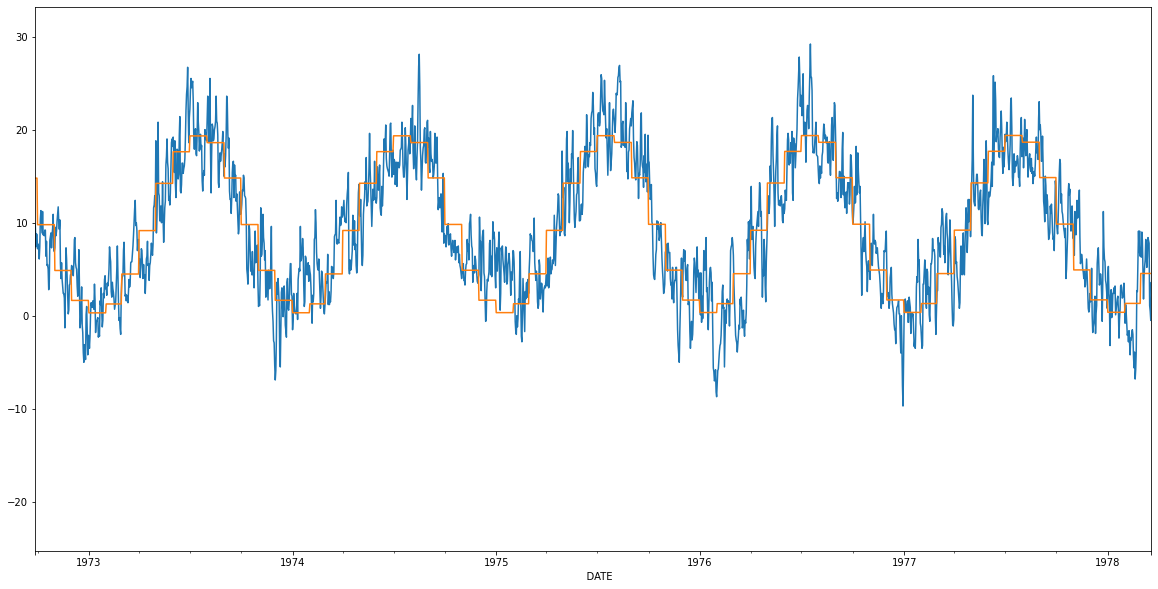

In [32]:
df['TG'].plot()
df['trend_seasonality'].plot(figsize=(20, 10))
plt.xlim(1000, 3000)

#### 4.2 Extract and Explore the Remainder

In [33]:
df['remainder'] = df['TG'] - df['trend_seasonality']

(1000.0, 3000.0)

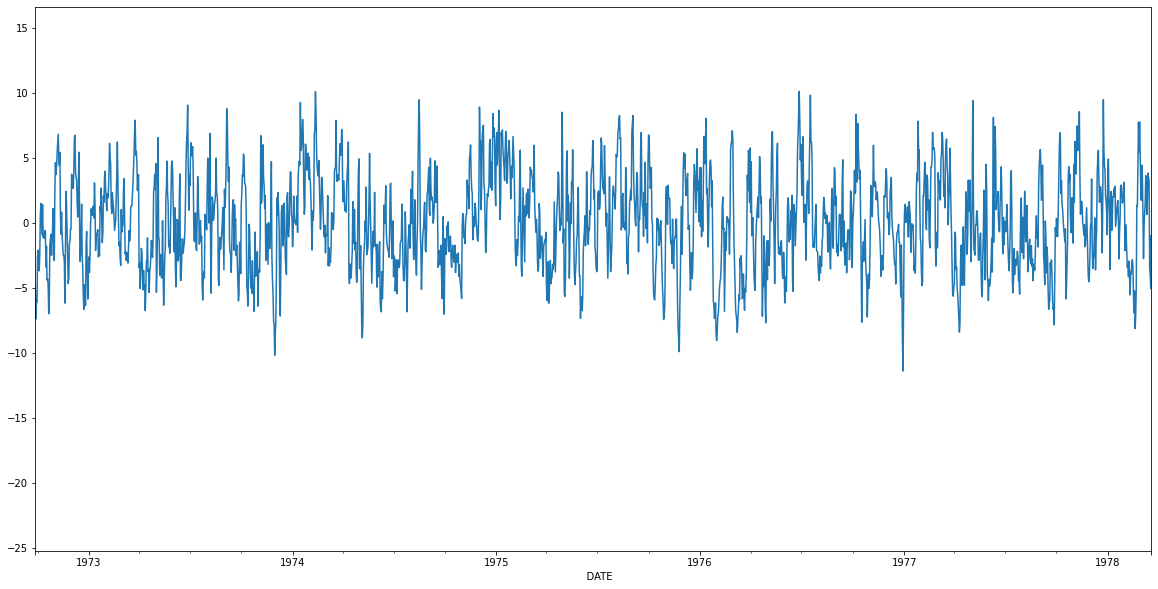

In [34]:
df['remainder'].plot(figsize=(20,10))
plt.xlim(1000, 3000)

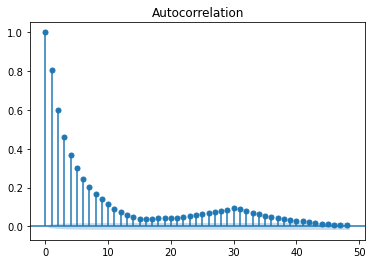

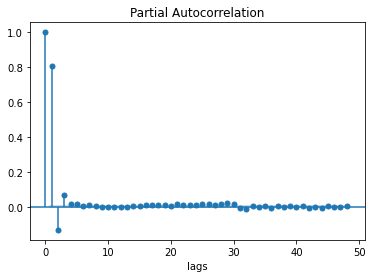

In [44]:
plot_acf(df['remainder'])
plot_pacf(df['remainder'], method='ywm')
plt.xlabel('lags');

##### Check Stationarity of Remainder

In [35]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""adf_stats: {adf_stats}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            CI 99%: {levels['1%']}
            CI 95%: {levels['5%']}
            CI 90%: {levels['10%']}
            information criterion (AIC): {information_criterion}
            """)

In [36]:
print_adf(df['remainder'])

adf_stats: -23.81906871590464
            p: 0.0 
            used lag: 58 
            number of observations: 53356
            CI 99%: -3.4304725656839286
            CI 95%: -2.8615941715902213
            CI 90%: -2.566798833732783
            information criterion (AIC): 240498.29157675535
            


##### >>>> p<0.05, Null Hypothesis rejected, remainder IS stationarry

#### 4.3 Modeling Remainder

In [37]:
# Check order
selected_order = ar_select_order(df['remainder'], maxlag = 12)
selected_order.ar_lags

C:\Users\maisa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\maisa\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\maisa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


array([1, 2, 3, 4])

In [38]:
# create and fit model
ar_model = AutoReg(endog=df['remainder'], lags=4).fit()

C:\Users\maisa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [39]:
ar_model.summary()

C:\Users\maisa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                53415
Model:                     AutoReg(4)   Log Likelihood             -120426.865
Method:               Conditional MLE   S.D. of innovations              2.307
Date:                Sun, 01 May 2022   AIC                              1.672
Time:                        19:46:42   BIC                              1.673
Sample:                    01-05-1876   HQIC                             1.672
                         - 03-30-2022                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     6.625e-05      0.010      0.007      0.995      -0.019       0.020
remainder.L1     0.9189      0.004    212.413      0.000       0.910       0.927
remainder.L2    -0.1929      0.006    -32.862      0.000      -0.204      -0.181
remainder.L3     0.0539      0.006      9.175      0.000       0.042       0.065
remainder.L4     0.0169      0.004      3.910      0.000       0.008       0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2577           -0.0000j            1.2577           -0.0000
AR.2            1.0121           -2.4990j            2.6962           -0.1888
AR.3            1.0121           +2.4990j            2.6962            0.1888
AR.4           -6.4662           -0.0000j            6.4662           -0.5000
-----------------------------------------------------------------------------
"""

In [40]:
# predict remainder
df['ar_model_4'] = ar_model.predict()

C:\Users\maisa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


(1000.0, 2000.0)

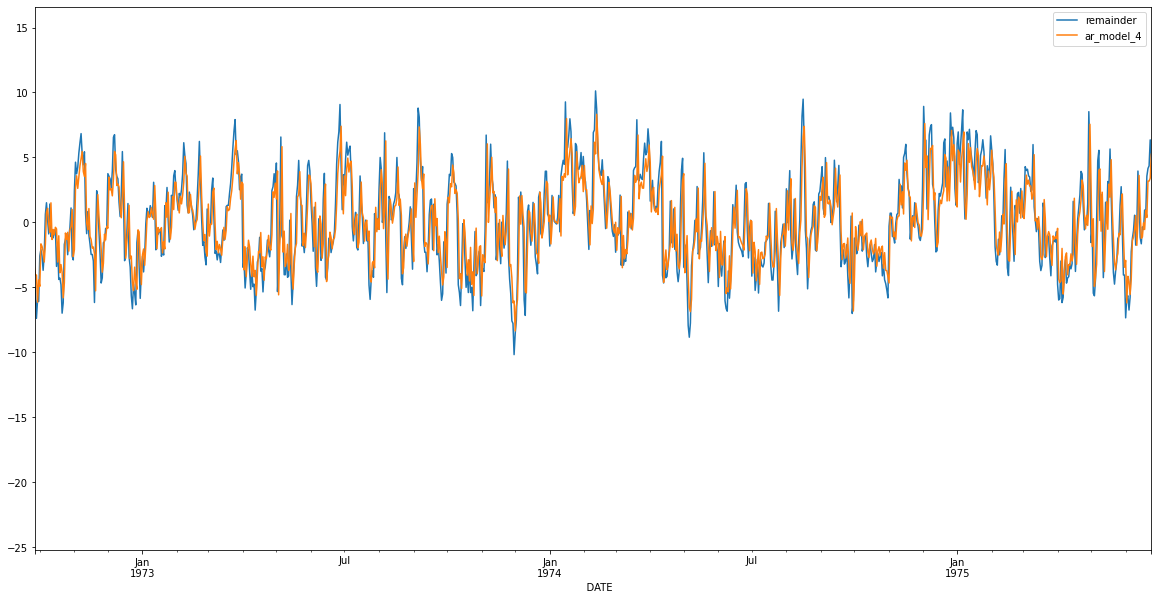

In [41]:
# Plot - original remainder and the prediction
df[['remainder', 'ar_model_4']].plot(figsize=(20,10))
plt.xlim(1000, 2000)

### 5. Create complete model

In [45]:
# add lag columns - from section 4.1, lags for remainder = 4
df['lag1'] = df['remainder'].shift(1)
df['lag2'] = df['remainder'].shift(2)
df['lag3'] = df['remainder'].shift(3)
df['lag4'] = df['remainder'].shift(4)

In [47]:
# Drop rows with missing values (due to lags)
df.dropna(inplace=True)

<AxesSubplot:>

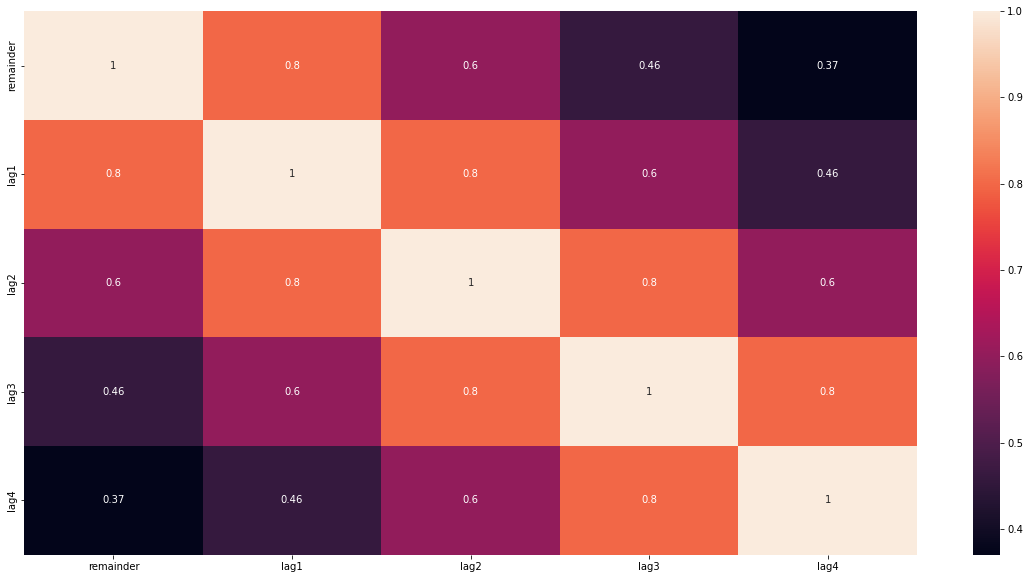

In [59]:
sns.heatmap(round(df[['remainder', 'lag1', 'lag2', 'lag3', 'lag4']].corr(), 2), annot=True)

In [73]:
# Assign X and y
X_full = df[['timestep', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'lag1', 'lag2', 'lag3', 'lag4']]
y_full = df[['TG']]

In [76]:
# fit model
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [77]:
# Create a new predictions column
df['predictions_full_model'] = m_full.predict(X_full)

(1000.0, 2000.0)

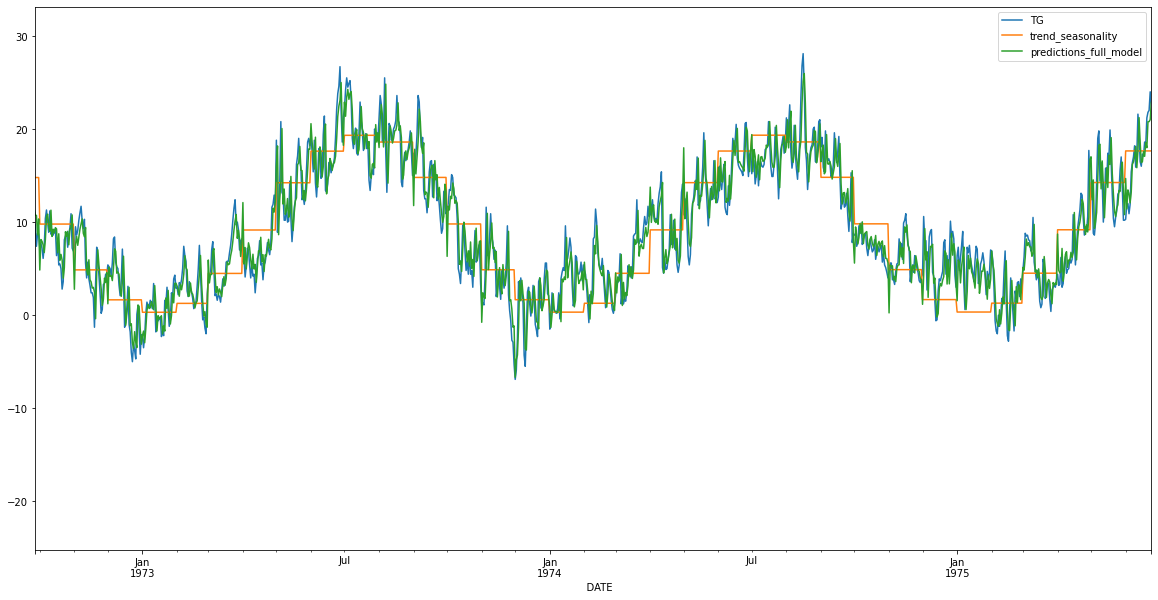

In [83]:
df['TG'].plot(legend=True)
df['trend_seasonality'].plot(legend=True)
df['predictions_full_model'].plot(legend=True)
plt.xlim(1000, 2000)

In [86]:
# MAE
np.mean(np.abs(df.predictions_full_model - df.TG))

1.7917915478118913

### 6. Evaluate the model

In [92]:
# Create the time series split
ts_split = TimeSeriesSplit(n_splits=5)
time_series_split = ts_split.split(X_full, y_full)

In [93]:
# run cross validation
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split,scoring='r2')
result

array([0.90507211, 0.91344355, 0.91372766, 0.90903683, 0.91863482])

In [94]:
result.mean()

0.9119829964789297